First columns in survival table:
Index(['Unnamed: 0', 'ttcos', 'censos', 'ttpfs', 'censpfs', 'Sex', 'Age',
       'ISS', 'LDH', 'MAF', 'MAFA', 'MAFB', 'NSD2', 'Cp_1q21', 'Cp_17p13',
       'Cp_1p22', 'ENSG00000228037', 'ENSG00000157911', 'ENSG00000142655',
       'ENSG00000149527', 'ENSG00000171621', 'ENSG00000142583',
       'ENSG00000287727', 'ENSG00000286448', 'ENSG00000173614',
       'ENSG00000171729', 'ENSG00000037637', 'ENSG00000287586',
       'ENSG00000159423', 'ENSG00000157916', 'ENSG00000157881',
       'ENSG00000048707', 'ENSG00000162444', 'ENSG00000180758',
       'ENSG00000184677', 'ENSG00000288398', 'ENSG00000131697',
       'ENSG00000197921', 'ENSG00000055070', 'ENSG00000225643'],
      dtype='object')

First rows of ttpfs / censpfs:
    ttpfs  censpfs
0   218.0        1
1  1240.0        1
2   697.0        1
3     NaN        0
4   628.0        1

Distribution of censpfs:
(array([0, 1]), array([257, 346]))

Number of MAF-related genes present in survival data: 251
Clinic

/rds/general/user/qj22/home/miniforge3/envs/rnaseq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/rds/general/user/qj22/home/miniforge3/envs/rnaseq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/rds/general/user/qj22/home/miniforge3/envs/rnaseq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/rds/general/user/qj22/home/miniforge3/envs/rnaseq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/rds/general/user/qj22/home/miniforge3/envs/rnaseq/lib/python3.10/


Best params from CV: {'coxnetsurvivalanalysis__alphas': array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754e-03, 9.23670857e-03,
       1.26896100e-02, 1.74332882e-02, 2.39502662e-02, 3.29034456e-02,
       4.52035366e-02, 6.21016942e-02, 8.53167852e-02, 1.17210230e-01,
       1.61026203e-01, 2.21221629e-01, 3.03919538e-01, 4.17531894e-01,
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01])}
Using alpha = 0.001

Selected features and coefficients (log HR):
ENSG00000163421   -13.106010
ENSG00000099998    -7.304787
ENSG00000165682    -6.586838
ENSG00000168386    -6.538028
ENSG00000162747    -6.506964
                     ...    
ENSG00000167772     5.955548
ENSG00000205710     6.323373
ENSG00000276231     6.560089
ENSG00000228278     6.795027
ENSG00000163464    13.532286
Length: 245, dtype: 

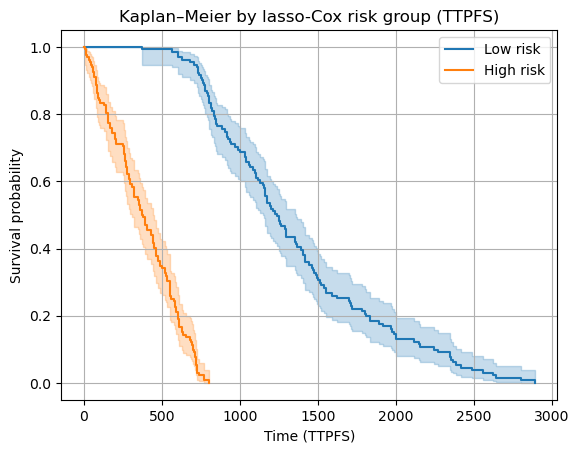

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, GridSearchCV

from lifelines import KaplanMeierFitter


# -------------------------------------------------
# 1. Load data
# -------------------------------------------------

surv_df = pd.read_csv("survival_gene.tsv", sep="\t")
beta_genes = pd.read_csv("BETA_MAF_combined_genes_EnsemblIDs.tsv", sep="\t")

# quick sanity checks
print("First columns in survival table:")
print(surv_df.columns[:40])
print("\nFirst rows of ttpfs / censpfs:")
print(surv_df[["ttpfs", "censpfs"]].head())
print("\nDistribution of censpfs:")
print(np.unique(surv_df["censpfs"], return_counts=True))

# make sure survival cols are numeric
surv_df["ttpfs"] = pd.to_numeric(surv_df["ttpfs"], errors="coerce")
surv_df["censpfs"] = pd.to_numeric(surv_df["censpfs"], errors="coerce")


# -------------------------------------------------
# 2. Decide which columns to use
# -------------------------------------------------

# MAF-related Ensembl IDs from your BETA list
maf_ensg = (
    beta_genes["Ensembl_Gene_ID"]
    .dropna()
    .astype(str)
    .unique()
)

# columns that actually appear in survival table
gene_cols = sorted(set(maf_ensg).intersection(surv_df.columns))
print(f"\nNumber of MAF-related genes present in survival data: {len(gene_cols)}")

# clinical + genomic covariates you want to include
clin_vars = [
    "MAF", "Sex", "Age", "ISS", "LDH", "MAFA", "MAFB", "NSD2",
    "Cp_1q21", "Cp_17p13", "Cp_1p22"
]

# keep only variables that really exist
clin_vars = [v for v in clin_vars if v in surv_df.columns]
print("Clinical variables used:", clin_vars)


# -------------------------------------------------
# 3. Build modelling dataframe (X, y)
# -------------------------------------------------

model_cols = ["ttpfs", "censpfs"] + clin_vars + gene_cols
model_df = surv_df[model_cols].copy()

# drop rows with missing survival info
model_df = model_df.dropna(subset=["ttpfs", "censpfs"])

feature_cols = clin_vars + gene_cols
X = model_df[feature_cols]

# scikit-survival response object
y = Surv.from_arrays(
    event=model_df["censpfs"].astype(bool),
    time=model_df["ttpfs"].astype(float)
)

print("\nX shape:", X.shape)
print("censpfs values:", np.unique(model_df["censpfs"], return_counts=True))

# 建模用的全部列
model_cols = ["ttpfs", "censpfs"] + clin_vars + gene_cols
model_df = surv_df[model_cols].copy()

# 丢掉 survival 或特征里含 NaN 的样本
model_df = model_df.dropna(subset=model_cols)

feature_cols = clin_vars + gene_cols
X = model_df[feature_cols]

y = Surv.from_arrays(
    event=model_df["censpfs"].astype(bool),
    time=model_df["ttpfs"].astype(float)
)

# -------------------------------------------------
# 4. Lasso Cox model (Coxnet) with CV
# -------------------------------------------------

coxnet = CoxnetSurvivalAnalysis(l1_ratio=1.0)  # pure lasso

# penalty strengths
alphas = 10.0 ** np.linspace(-3, 1, 30)  # 0.001 ... 10

pipe = make_pipeline(
    StandardScaler(),
    coxnet
)

param_grid = {
    "coxnetsurvivalanalysis__alphas": [alphas]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gcv = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"  # any monotone score is OK
)

gcv.fit(X, y)

print("\nBest params from CV:", gcv.best_params_)

best_model = gcv.best_estimator_
cox_fitted = best_model.named_steps["coxnetsurvivalanalysis"]

# -------------------------------------------------
# 5. Extract non-zero coefficients (selected features)
# -------------------------------------------------

coef_path = cox_fitted.coef_   # (n_features,) or (n_features, n_alphas)

if coef_path.ndim == 2:
    best_alpha_idx = np.argmax(cox_fitted.deviance_ratio_)
    coef_vec = coef_path[:, best_alpha_idx]
    print("Using alpha =", cox_fitted.alphas_[best_alpha_idx])
else:
    coef_vec = coef_path

coef = pd.Series(coef_vec, index=feature_cols)
selected = coef[coef != 0].sort_values()

print("\nSelected features and coefficients (log HR):")
print(selected)

selected.to_csv("lasso_cox_selected_features_ttpfs.csv")


# -------------------------------------------------
# 6. Risk score & C-index
# -------------------------------------------------

risk_score = best_model.predict(X)
risk_score = np.asarray(risk_score).ravel()

c_index, c_index_se = concordance_index_censored(
    event_indicator=model_df["censpfs"].astype(bool),
    event_time=model_df["ttpfs"].astype(float),
    estimate=risk_score
)[:2]

print(f"\nConcordance index (TTPFS): {c_index:.3f} ± {c_index_se:.3f}")


# -------------------------------------------------
# 7. KM curves for high vs low risk
# -------------------------------------------------

median_risk = np.median(risk_score)
# use >= so both groups are non-empty in most cases
risk_group = np.where(risk_score >= median_risk, "High risk", "Low risk")
model_df = model_df.assign(risk_group=risk_group, risk_score=risk_score)

print("\nGroup sizes:")
print(model_df["risk_group"].value_counts())

kmf = KaplanMeierFitter()

plt.figure()

for group in ["Low risk", "High risk"]:
    mask = model_df["risk_group"] == group
    durations = model_df.loc[mask, "ttpfs"].astype(float)
    events = model_df.loc[mask, "censpfs"].astype(bool)

    # drop any remaining NaNs
    valid = durations.notna() & events.notna()
    durations = durations[valid]
    events = events[valid]

    if len(durations) == 0:
        print(f"{group}: no valid data, skipping")
        continue

    kmf.fit(
        durations=durations,
        event_observed=events,
        label=group
    )
    kmf.plot(ci_show=True)

plt.xlabel("Time (TTPFS)")
plt.ylabel("Survival probability")
plt.title("Kaplan–Meier by lasso-Cox risk group (TTPFS)")
plt.grid(True)
plt.show()